In [1]:
%load_ext autoreload

import torch
import torch.nn as nn
import torch.nn.functional as F

import lightning as L

from torch.utils.data import DataLoader, TensorDataset

from matplotlib import pyplot as plt

import numpy as np

import json

In [2]:
torch.backends.cpu.get_cpu_capability()

'AVX512'

In [3]:
%autoreload 2
from ml_pws.data.nonlinear_dataset import generate_nonlinear_data, ARModel, LogisticModel

In [78]:
with open("../data/ar_data.json", "r") as file:
    data = json.load(file)
s_trajs = np.asarray(data['TrainingData']['S'])
x_trajs = np.asarray(data['TrainingData']['X'])
train_dataset = TensorDataset(torch.tensor(s_trajs, dtype=torch.float32), torch.tensor(x_trajs, dtype=torch.float32))
validation_dataset = TensorDataset(torch.tensor(data['ValidationData']['S'], dtype=torch.float32), torch.tensor(data['ValidationData']['X'], dtype=torch.float32))
len(train_dataset), len(validation_dataset)

(1000, 2000)

Text(0.5, 0, 'lag')

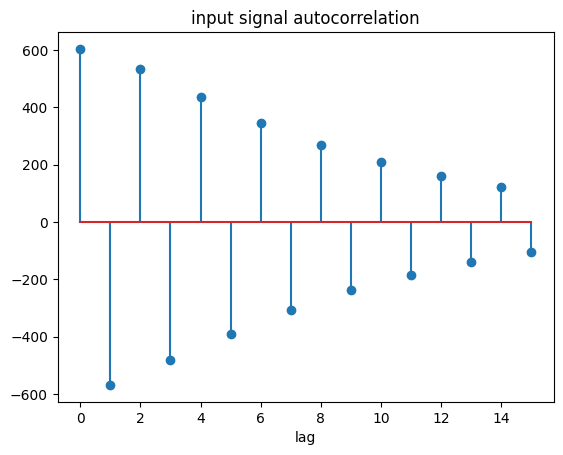

In [79]:
lags = np.arange(-s_trajs.shape[-1]+1, s_trajs.shape[-1])
max_lags = 15
acf = np.mean(np.stack([np.correlate(s, s, mode='full') for s in s_trajs]), axis=0)
pos = np.logical_and(lags >= 0, lags <= max_lags)
plt.stem(lags[pos], acf[pos])
plt.title('input signal autocorrelation')
plt.xlabel('lag')

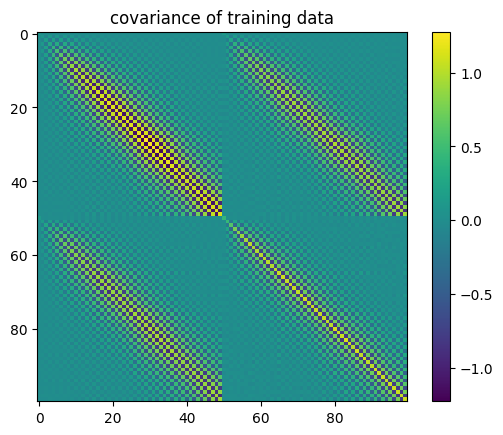

In [ ]:
plt.imshow(np.cov(np.concat([s_trajs / s_trajs.std(), x_trajs / x_trajs.std()], axis=1).T))
plt.title('covariance of training data')
plt.colorbar()

Text(0.5, 1.0, 'output')

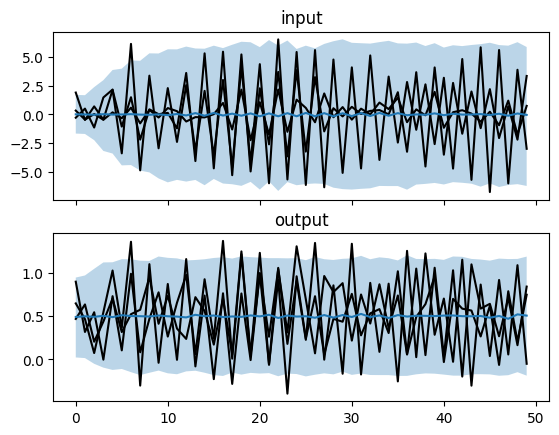

In [182]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(s_trajs[:3].T, color='black')
ax2.plot(x_trajs[:3].T, color='black')
ax1.fill_between(np.arange(s_trajs.shape[1]), *np.quantile(s_trajs, np.array([0.05, 0.95]), axis=0), alpha=0.3)
ax1.plot(s_trajs.mean(0))
ax2.fill_between(np.arange(x_trajs.shape[1]), *np.quantile(x_trajs, np.array([0.05, 0.95]), axis=0), alpha=0.3)
ax2.plot(x_trajs.mean(0))
ax1.set_title('input')
ax2.set_title('output')

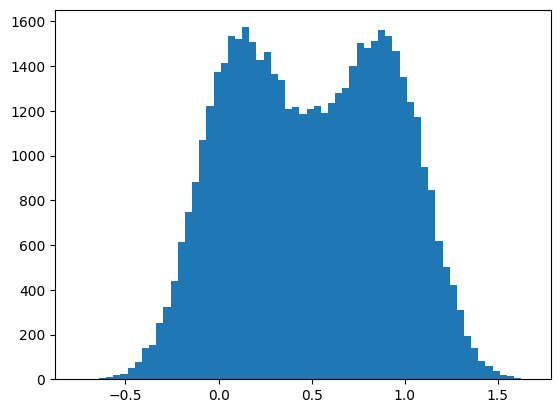

In [82]:
plt.hist(x_trajs.reshape(-1), bins='auto');

# RNN model

## Marginal Model

The `GaussianRNN` is a PyTorch module that models a sequence of data using an RNN architecture and outputs a Gaussian distribution at each time step. Below are the key features:

### Features
- **Input Handling:** 
  - Accepts input sequences of shape `(batch_size, seq_len)`.
  - Preprocesses inputs by shifting them right and setting the first element to zero.
  
- **Architecture:**
  - **RNN Layer:** A vanilla RNN with configurable `input_size`, `hidden_size`, and `num_layers`.
  - **Output Layer:** A linear layer maps RNN outputs to two parameters: the mean and log-variance of the Gaussian distribution at each time step.

- **Outputs:**
  - **Mean and Log-Variance:** Separate outputs for the predicted mean and log-variance of the Gaussian distribution, both with shape `(batch_size, seq_len)`.
  - **Log Probability Calculation (`log_p`):** Computes the log probability of the input sequence given the Gaussian predictions, using the formula:
    $$
    \text{log\_prob} = -\frac{1}{2} \left(\log(2 \pi \sigma^2) + \frac{(x - \mu)^2}{\sigma^2}\right)
    $$
    where $\mu=\text{mean}$ and $\sigma^2 = \exp(\text{log\_var})$.

### Usage
1. Initialize with desired RNN configuration:
   ```python
   model = GaussianRNN(input_size=1, hidden_size=128, num_layers=1)
   ```
2. Forward Pass:
   ```python
   mean, log_var = model(x)  # x is the input sequence
   ```

3. Log Probability:
   ```python
   log_p = model.log_p(x)
   ```


## Conditional Model

The `ConditionalGaussianRNN` is a PyTorch model designed for probabilistic sequence modeling of the conditional distribution $P(x|s)$. It extends the `GaussianRNN` by incorporating an additional conditional input $s$ into the sequence modeling process.

## Features

- **Conditioning Input $s$:**
  - $s$ is a context variable with shape `(batch_size, seq_len)`, representing external information that conditions the distribution of $x$.

- **Input Handling:**
  - The model takes two inputs:
    - \( s \): The conditioning sequence.
    - \( x \): The target sequence whose conditional distribution is modeled.
  - The input \( x \) is shifted right, with the first element set to zero, to mimic autoregressive behavior.

- **Architecture:**
  - **RNN Layer:** Takes a concatenated input of $s$ and the shifted $x$ along the feature dimension, allowing the model to condition the sequence distribution on $s$.
  - **Output Layer:** Outputs the mean and log-variance of the Gaussian distribution for each time step.

- **Outputs:**
  - **Mean and Log-Variance:** Predicted mean and log-variance of the conditional Gaussian distribution \( P(x|s) \), both with shape `(batch_size, seq_len)`.
  - **Log Probability Calculation (`log_p`):** Computes the log probability of the target sequence \( x \) conditioned on \( s \), using:
    $$
    \text{log\_prob} = -\frac{1}{2} \left(\log(2 \pi \text{var}) + \frac{(x - \text{mean})^2}{\text{var}}\right)
    $$
    where $\text{var} = e^{\text{log\_var}}$.

In [83]:
from ml_pws.models.doe_estimator import DoeEstimator

In [84]:
train_loader = DataLoader(train_dataset, batch_size=25, shuffle=True)
doe_estimator = DoeEstimator(1, 64, 2)
trainer = L.Trainer(max_epochs=50)
trainer.fit(model=doe_estimator, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/reinhardt/.local/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name              | Type                   | Params | Mode 
---------------------------------------------------------------------
0 | conditional_model | ConditionalGaussianRNN | 12.8 K | train
1 | marginal_model    | GaussianRNN            | 12.7 K | train
---------------------------------------------------------------------
25.5 K    Trainable params
0         Non-trainable params
25.5 K    Total params
0.102     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode
/home/reinhardt/.local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may b

Epoch 0:   0%|          | 0/40 [00:00<?, ?it/s] 

Epoch 49: 100%|██████████| 40/40 [00:00<00:00, 51.28it/s, v_num=27, train_loss_step=-2.00, train_loss_epoch=-1.92]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 40/40 [00:00<00:00, 50.62it/s, v_num=27, train_loss_step=-2.00, train_loss_epoch=-1.92]


length,MI,checkpoint_path
i64,f32,str
1,0.365411,"""lightning_logs/version_27/chec…"
2,0.730909,"""lightning_logs/version_27/chec…"
3,1.160791,"""lightning_logs/version_27/chec…"
4,1.545205,"""lightning_logs/version_27/chec…"
5,1.923273,"""lightning_logs/version_27/chec…"
…,…,…
46,13.637316,"""lightning_logs/version_27/chec…"
47,13.906662,"""lightning_logs/version_27/chec…"
48,14.173248,"""lightning_logs/version_27/chec…"


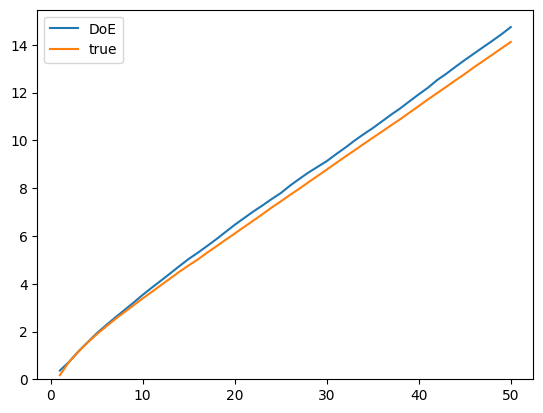

In [166]:
import polars as pl

test_data = validation_dataset.tensors
checkpoint_path = "lightning_logs/version_27/checkpoints/epoch=49-step=2000.ckpt"
model = DoeEstimator.load_from_checkpoint(checkpoint_path)
mi = model.estimate_mutual_information(*test_data)
doe_data = pl.DataFrame({"length": np.arange(mi.shape[-1]) + 1, "MI": mi.mean(0).cumsum(0).numpy(), "checkpoint_path": checkpoint_path})
plt.plot(doe_data['length'], doe_data['MI'], label='DoE')
plt.plot(data["Step"], data['MutualInformation'], label='true')
plt.ylim(0, None)
plt.legend()
doe_data.write_csv("doe_estimate.csv")
doe_data

In [180]:
data["Parameters"]

{'Gain': 1.0,
 'ARCoeffs': [0.2881365609398022, 0.22070961647376935, -1.010492634789413],
 'Noise': 0.2,
 'Decay': 0.2,
 'Sigma': 1.0}

# Contrastive Learning (InfoNCE)

In [ ]:
from ml_pws.models.contrastive_mi import ContrastiveEstimator

ContrastiveEstimator(
  (score_fn): ScoringFunction(
    (conv_layers): Sequential(
      (0): Conv1d(2, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): ReLU()
      (2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): ReLU()
      (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (5): ReLU()
      (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (7): ReLU()
    )
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [136]:
lengths = [1, 2, 4, 6, 8]
lengths


[1, 2, 4, 6, 8]

In [ ]:
# contrastive_models = {}

# for length in lengths:
#     train_loader = DataLoader(TensorDataset(*train_dataset[:, :length]), batch_size=50, shuffle=True)
#     val_loader = DataLoader(TensorDataset(*validation_dataset[:, :length]), batch_size=100)

#     contrastive_estimator = ContrastiveEstimator(1, 64, 4)
#     trainer = L.Trainer(max_epochs=10)
#     trainer.fit(model=contrastive_estimator, train_dataloaders=train_loader, val_dataloaders=val_loader)
#     model_path = trainer.checkpoint_callback.best_model_path
#     contrastive_models[length] = model_path

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type            | Params | Mode 
-----------------------------------------------------
0 | score_fn | ScoringFunction | 37.6 K | train
-----------------------------------------------------
37.6 K    Trainable params
0         Non-trainable params
37.6 K    Total params
0.150     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/reinhardt/.local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/reinhardt/.local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/reinhardt/.local/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 20/20 [00:03<00:00,  6.61it/s, v_num=35, train_loss_step=3.790, train_loss_epoch=3.570]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:03<00:00,  6.59it/s, v_num=35, train_loss_step=3.790, train_loss_epoch=3.570]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type            | Params | Mode 
-----------------------------------------------------
0 | score_fn | ScoringFunction | 37.6 K | train
-----------------------------------------------------
37.6 K    Trainable params
0         Non-trainable params
37.6 K    Total params
0.150     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 20/20 [00:04<00:00,  4.30it/s, v_num=36, train_loss_step=3.280, train_loss_epoch=3.200]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:04<00:00,  4.29it/s, v_num=36, train_loss_step=3.280, train_loss_epoch=3.200]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type            | Params | Mode 
-----------------------------------------------------
0 | score_fn | ScoringFunction | 37.6 K | train
-----------------------------------------------------
37.6 K    Trainable params
0         Non-trainable params
37.6 K    Total params
0.150     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode



Epoch 9: 100%|██████████| 20/20 [00:04<00:00,  4.36it/s, v_num=37, train_loss_step=2.720, train_loss_epoch=2.500]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:04<00:00,  4.35it/s, v_num=37, train_loss_step=2.720, train_loss_epoch=2.500]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type            | Params | Mode 
-----------------------------------------------------
0 | score_fn | ScoringFunction | 37.6 K | train
-----------------------------------------------------
37.6 K    Trainable params
0         Non-trainable params
37.6 K    Total params
0.150     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode



Epoch 9: 100%|██████████| 20/20 [00:04<00:00,  4.09it/s, v_num=38, train_loss_step=2.150, train_loss_epoch=2.010]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:04<00:00,  4.08it/s, v_num=38, train_loss_step=2.150, train_loss_epoch=2.010]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name     | Type            | Params | Mode 
-----------------------------------------------------
0 | score_fn | ScoringFunction | 37.6 K | train
-----------------------------------------------------
37.6 K    Trainable params
0         Non-trainable params
37.6 K    Total params
0.150     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode



Epoch 9: 100%|██████████| 20/20 [00:04<00:00,  4.27it/s, v_num=39, train_loss_step=1.490, train_loss_epoch=1.590]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:04<00:00,  4.26it/s, v_num=39, train_loss_step=1.490, train_loss_epoch=1.590]


In [165]:
import polars as pl

def contrastive_mi(length, chkpt_path):
    size = 1000
    test_data = validation_dataset[:size, :length]
    model = ContrastiveEstimator.load_from_checkpoint(chkpt_path)
    with torch.no_grad():
        mi = np.log(size) - model(*test_data)
    return {"length": length, "MI": mi, "logN": np.log(size), "model_path": chkpt_path}

# contrastive_data = pl.DataFrame(map(contrastive_mi, contrastive_models.keys(), contrastive_models.values())).sort('length')
contrastive_data.write_csv("infonce_estimate.csv")
contrastive_data

length,MI,logN,model_path
i64,f64,f64,str
1,0.379955,6.907755,"""/home/reinhardt/ml-pws/noteboo…"
2,0.724323,6.907755,"""/home/reinhardt/ml-pws/noteboo…"
4,1.410111,6.907755,"""/home/reinhardt/ml-pws/noteboo…"
6,2.042599,6.907755,"""/home/reinhardt/ml-pws/noteboo…"
8,2.584308,6.907755,"""/home/reinhardt/ml-pws/noteboo…"
10,3.064266,6.907755,"""/home/reinhardt/ml-pws/noteboo…"
20,5.03454,6.907755,"""/home/reinhardt/ml-pws/noteboo…"
30,6.013926,6.907755,"""/home/reinhardt/ml-pws/noteboo…"
40,6.374468,6.907755,"""/home/reinhardt/ml-pws/noteboo…"


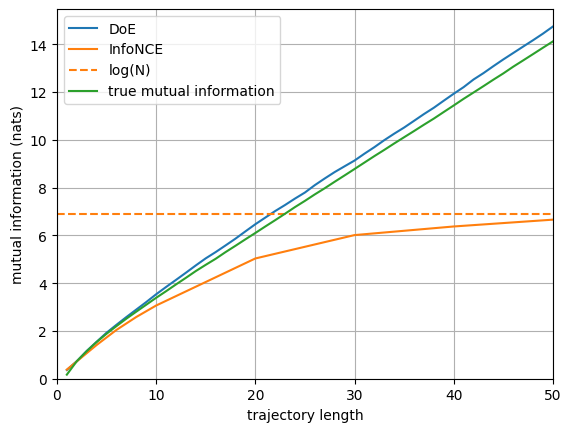

In [164]:
plt.plot(doe_data['length'], doe_data['MI'], label="DoE")
plt.plot(contrastive_data['length'], contrastive_data['MI'], label='InfoNCE')
plt.axhline(y=np.log(1000), label='log(N)', color='C1', linestyle='--')
plt.plot(data["Step"], data['MutualInformation'], label='true mutual information')
plt.xlabel('trajectory length')
plt.ylabel('mutual information (nats)')
plt.grid()
plt.xlim(0, 50)
plt.ylim(0, None)
plt.legend()

# Compare

In [70]:
import polars as pl

In [72]:
test_loader = DataLoader(validation_dataset, batch_size=1000)
results = []

doemod = DoeEstimator.load_from_checkpoint("lightning_logs/version_25/checkpoints/epoch=49-step=2000.ckpt")
cmod = ContrastiveEstimator.load_from_checkpoint("lightning_logs/version_26/checkpoints/epoch=9-step=200.ckpt")

for i, test_data in enumerate(test_loader):
    doe_mi = doemod.estimate_mutual_information(*test_data).mean(0).sum()

    with torch.no_grad():
        c_mi = np.log(test_data[0].size(0)) - cmod(*test_data)

    results.append({'batch': i, 'doe_result': doe_mi, 'infonce_result': c_mi})

pl.DataFrame(results)


batch,doe_result,infonce_result
i64,f64,f64
0,3.411801,2.956509
1,3.426771,3.012552
2,3.56904,3.090619
3,3.512383,3.104181
4,3.494195,3.014528
5,3.458755,3.076314
6,3.343629,2.912976
7,3.469634,3.007289
8,3.445126,3.016343


In [73]:
pl.DataFrame(results).write_csv('doe_vs_infonce.csv')

(0.0, 3.601842761039734)

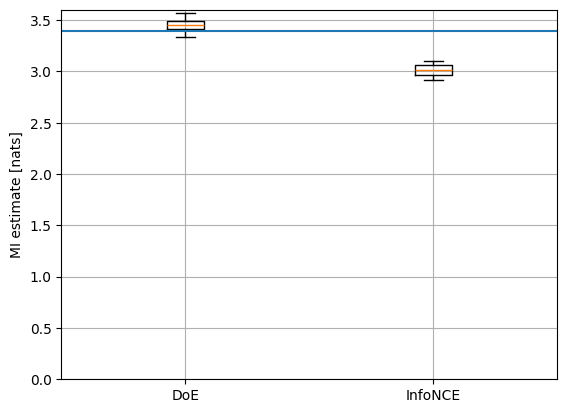

In [77]:
df = pl.read_csv('doe_vs_infonce.csv')

plt.boxplot([df['doe_result'], df['infonce_result']], tick_labels=['DoE', 'InfoNCE'])
plt.axhline(y=data["MutualInformation"][-1])
plt.ylabel('MI estimate [nats]')
plt.grid()
plt.ylim(0)
# plt.axhline(34)

# MINE

In [14]:
class MineNetwork(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int=1, kernel_size: int = 3):
        super().__init__()
        self.num_layers = num_layers

        # Build convolutional layers
        layers = []
        for i in range(num_layers):
            in_channels = input_size if i == 0 else hidden_size
            layers.append(nn.Conv1d(in_channels, hidden_size, kernel_size, padding=kernel_size // 2))
            layers.append(nn.ReLU())
        self.conv_layers = nn.Sequential(*layers)

        # Final linear layer to output a scalar
        self.output_layer = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor):
        """
        Forward pass through the network.
        
        Args:
        - x: Input tensor of shape (batch_size, seq_len, num_features).

        Returns:
        - Output tensor of shape (batch_size,).
        """
        # Permute input to match Conv1D expectations: (batch_size, num_features, seq_len)
        x = x.permute(0, 2, 1)

        # Pass through convolutional layers
        x = self.conv_layers(x)  # (batch_size, hidden_size, seq_len)

        # Aggregate features by global average pooling
        x = x.mean(dim=2)  # (batch_size, hidden_size)

        # Final linear layer
        x = self.output_layer(x).squeeze(-1)  # (batch_size,)
        return x

In [16]:
class MINE:
    def __init__(self, input_size, hidden_size, num_layers=4, kernel_size=10, lr=1e-3):
        self.net = MineNetwork(input_size, hidden_size, num_layers=num_layers, kernel_size=kernel_size)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=lr)

    def train_step(self, joint_samples, marginal_samples):
        joint_preds = self.net(joint_samples)
        marginal_preds = self.net(marginal_samples)

        mi_estimate = torch.mean(joint_preds, dim=0) - torch.logsumexp(marginal_preds, dim=0)

        # Negate to create a loss function (maximize MI estimate)
        loss = -mi_estimate.mean()

        # Backpropagation
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def estimate_mutual_information(self, joint_samples, marginal_samples):
        """
        Estimate mutual information using the current network.
        """
        with torch.no_grad():
            joint_preds = self.net(joint_samples)
            marginal_preds = self.net(marginal_samples)

            # Compute the mutual information lower bound
            N = torch.tensor(marginal_preds.size(0), dtype=torch.float32)
            mi_estimate = torch.mean(joint_preds, dim=0) - torch.logsumexp(marginal_preds, dim=0) + torch.log(N)

        return mi_estimate

In [19]:
mine = MINE(2, 64, 4)

writer = SummaryWriter('../metrics/MINE_conv')

num_epochs = 500

s = ar_model.sample(torch.zeros(1000, 3), 100)
x = torch.tensor(x_model.sample(s_trajs.numpy(), seed=3))
x_marginal = torch.tensor(x_model.sample(ar_model.sample(torch.zeros(1000, 3), 100).numpy(), seed=4))

batch_size=128
joint_loader = DataLoader(TensorDataset(s, x), batch_size=batch_size, shuffle=True)
marginal_loader = DataLoader(TensorDataset(s, x_marginal), batch_size=batch_size, shuffle=True)


# training loop
for epoch in range(num_epochs):
    epoch_loss = 0.0

    for (joint_samples, marginal_samples) in zip(joint_loader, marginal_loader):
        joint_samples = torch.stack(joint_samples, dim=-1)
        marg_samples = torch.stack(marginal_samples, dim=-1)
        loss = mine.train_step(joint_samples, marg_samples)

    writer.add_scalar("loss", loss, epoch)

writer.close()

In [20]:
mine.estimate_mutual_information(torch.stack([s, x], dim=-1), torch.stack([s, x_marginal], dim=-1))

tensor(97083.5312)